In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import matplotlib
import datetime
matplotlib.rcParams.update({'font.size': 22})
plt.rcParams['font.family']=['STFangsong']
starttime = datetime.datetime.now()
###########
#改變時間格式
###########
def Time_processing(d, t, ms):
    d = d.replace('/', '-')
    ds = d.split('-')
    d = ds[0] + '-' + ds[1].zfill(2) + '-' + ds[2].zfill(2)
    ts = t.split(':')
    t = ts[0].zfill(2) + ':' + ts[1].zfill(2) + ':' + ts[2].zfill(2)
    return d + ' ' + t + '.' + str(ms).zfill(3)


def Add_delta(df):
    xs = df['X軸機械座標'].values
    ys = df['Y軸機械座標'].values
    zs = df['Z軸機械座標'].values
    dx = np.zeros(len(xs))
    dy = np.zeros(len(ys))
    dz = np.zeros(len(zs))
    
    for i in range(1,len(xs)):
        dx[i] = np.abs(xs[i] - xs[i-1])
        dy[i] = np.abs(ys[i] - ys[i-1])
        dz[i] = np.abs(zs[i] - zs[i-1])
    df['dx'] = dx
    df['dy'] = dy
    df['dz'] = dz
    return df

###########
#獨進所有的plc.csv檔，並將其concate在一起成為一個dataframe 傳回
###########
def Read_plc(plc_dir):
    csv_files = os.listdir(plc_dir)
    df = pd.DataFrame()
    df_list = []
    for c in sorted(csv_files):
        if c[-4:] == '.csv': 
            print(c)
            df_ = pd.read_csv(plc_dir + c, encoding='big5', low_memory=False)
            df_['file'] = c
            df_list.append(df_)
    df = pd.concat(df_list)
    df['time'] = np.vectorize(Time_processing)(df['日期'],df['時間'],df['毫秒'])
    df.drop(['日期','時間','毫秒'],axis=1, inplace=True)
    df['實際進給'] = pd.to_numeric(df['實際進給'], errors='coerce').fillna(0)
    df['實際轉速'] = pd.to_numeric(df['實際轉速'], errors='coerce').fillna(0)
    df['設定進給'] = pd.to_numeric(df['設定進給'], errors='coerce').fillna(0)
    df['設定轉速'] = pd.to_numeric(df['設定轉速'], errors='coerce').fillna(0)
    df['Z軸機械座標'] = df.apply(lambda x: round(x['Z軸機械座標'],4), axis=1)
    df = Add_delta(df)
    print(df.columns)
    df.columns = ['prog', 'cut', 'set_feed', 'set_speed', 'loading', 'x', 'y', 'z',
       'cut_time', 'real_feed', 'real_speed', 'ratio', 'file', 'time', 'dx', 'dy', 'dz']
    
    print('Read_plc() finish!!!')
    print('time cost:', datetime.datetime.now()-starttime)
    print('ori_df len:', len(df))
    return df



def Time_diff(x):
    t1 = datetime.datetime.strptime(x['time_begin'], '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000
    t2 = datetime.datetime.strptime(x['time_end'], '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000
    return t2 - t1
    
def Preprocess_df(plc_dir):
    plc_df = Read_plc(plc_dir)
    print(len(plc_df))
    sql =("SELECT min(time) AS time_begin, max(time) AS time_end,"
                     "prog, loading, x, y, z,"
                     "real_feed, real_speed, set_feed, set_speed, file, ratio, "
                     "sum(dx) as dx , sum(dy) as dy, sum(dz) as dz "
                     "FROM plc_df "
                     "WHERE prog IS NOT NULL and real_feed>5000 and real_speed>1000 "
                     " and set_feed==10000 and set_speed==2000 and ratio==100 and dz==0"
                     " GROUP BY prog, loading, x, y, z, "
                     "         real_feed, real_speed, file "
                     "ORDER BY time_begin, time_end")
    data = sqldf(sql, locals())
    #data.reset_index(level=0, inplace=True)
    #data['index0'] = data.index
    data['dt'] = data.apply(Time_diff,axis=1)

    return data, plc_df


In [2]:
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 5000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    pred_train_y = model.predict(train_X, num_iteration=model.best_iteration)
    print('train, val, test len:')
    print(len(train_X), len(val_X), len(test_X))
    return pred_test_y, model, pred_val_y, pred_train_y


In [3]:
def Draw_Whole_life(train_rms, val_rms, test_rms, interval):
    plt.figure(figsize=(15,9))
    y1_ = list(train_rms)
    plt.scatter(range(len(y1_)), y1_,c='r', label='baseline_train')

    y2_ = list(val_rms)
    plt.scatter(range(len(y1_),len(y2_)+len(y1_)), y2_,c='g', label='baseline_valid')
    y3_ = list(test_rms)
    plt.scatter(range(len(y1_)+len(y2_), len(y1_)+len(y2_)+len(y3_)), y3_,c='b',label='others')
    plt.legend(loc='best')
    plt.xlabel('group data index (group=' + str(interval) + ' points)')
    plt.ylabel('1-RMSE')
    plt.show()

In [4]:
def Cal_rmse(pred_test_y, model, pred_val_y, pred_train_y, train_y, val_y, test_y, interval=40):
    train_rms = []
    val_rms = []
    test_rms = []
    for i in range(0, len(pred_train_y)-interval):
        p = pred_train_y[i:i+interval]
        r = train_y.values[i:i+interval]
        train_rms.append(1-((p-r)**2).mean()**0.5)  

    for i in range(0, len(pred_val_y)-interval):
        p = pred_val_y[i:i+interval]
        r = val_y.values[i:i+interval]
        val_rms.append(1-((p-r)**2).mean()**0.5)    

    for i in range(0, len(pred_test_y)-interval):
        p = pred_test_y[i:i+interval]
        r = test_y.values[i:i+interval]
        test_rms.append(1-((p-r)**2).mean()**0.5)  
    print('train, val, test, rms len:')
    print(len(train_rms), len(val_rms), len(test_rms))
    Draw_Whole_life(train_rms, val_rms, test_rms, interval)
    return train_rms, val_rms, test_rms


In [5]:
def Cal_imp(model):
    fig, ax = plt.subplots(figsize=(15,9))
    lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
    ax.grid(False)
    plt.title("LightGBM - Feature Importance", fontsize=15)
    plt.show()

In [6]:
def Find_pred_diff(test_X, test_y, pred_test_y, high=0.7, low=0.5):
    tmp_test = test_X.copy()
    tmp_test['real_y'] = test_y.values
    tmp_test['pred_y'] = pred_test_y
    tmp_test['diff_y'] = (tmp_test['real_y'] - tmp_test['pred_y'])
    print(tmp_test[tmp_test['diff_y']>high].describe())
    print(tmp_test[tmp_test['diff_y']<low].describe())

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def Map(path):
    df, df_ori = Preprocess_df(path)
    df = df[df.prog.str.startswith('G')]
    print('after process, df.len:', len(df))
    df['gcode'] = df.prog.str[1:2]
    dummy = pd.get_dummies(df.gcode.values,prefix='G')
    df['G_1'] = dummy['G_1'].values
    df['G_2'] = dummy['G_2'].values
    df['G_3'] = dummy['G_3'].values
    df['dd'] = (df['dx']**2+df['dy']**2)**0.5
    cols = ['real_feed', 'real_speed', 'dd', 'dx', 'dy',  'dt', 'G_1', 'G_2', 'G_3']#, 'x', 'y', 'z']#
    #cols = ['real_feed', 'real_speed', 'dx', 'dy', 'dt', 'G_1', 'G_2', 'G_3']

    df1 = df[cols]#, 'G_1', 'G_2', 'G_3']]
    y = np.log1p(df['loading'])

    x = df1.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    df2 = pd.DataFrame(x_scaled)
    df2.columns = df1.columns

    N = 10
    INTERVAL = 40
    INTERVAL1 = 400
    
    base_X = df2[:int(len(df2)/N)]
    base_y = y[:int(len(df2)/N)]
    test_X = df2[int(len(df2)/N):]
    test_y = y[int(len(df2)/N):]
    train_X, val_X, train_y, val_y = train_test_split( base_X, base_y, test_size=0.33, random_state=42)
    pred_test_y, model, pred_val_y, pred_train_y = run_lgb(train_X, train_y, val_X, val_y, test_X)
    train_rms, val_rms, test_rms = Cal_rmse(pred_test_y, model, pred_val_y, pred_train_y, train_y, val_y, test_y, INTERVAL)
    train_rms, val_rms, test_rms = Cal_rmse(pred_test_y, model, pred_val_y, pred_train_y, train_y, val_y, test_y, INTERVAL1)
    
    Cal_imp(model)
    Find_pred_diff(test_X, test_y, pred_test_y, high=0.7, low=0.5)
    return df, df1, df2

M03S0032808.csv
M03S0032809.csv
M03S0032810.csv
M03S0032811.csv
M03S0032813.csv
M03S0032814.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:00:11.559947
ori_df len: 216738
216738
after process, df.len: 15742
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.174165
[200]	valid_0's rmse: 0.166099
[300]	valid_0's rmse: 0.163966
[400]	valid_0's rmse: 0.162747
[500]	valid_0's rmse: 0.161913
[600]	valid_0's rmse: 0.16142
[700]	valid_0's rmse: 0.161153
[800]	valid_0's rmse: 0.160816
[900]	valid_0's rmse: 0.160572
[1000]	valid_0's rmse: 0.160473
Early stopping, best iteration is:
[927]	valid_0's rmse: 0.160424
train, val, test len:
1054 520 14168
train, val, test, rms len:
1014 480 14128


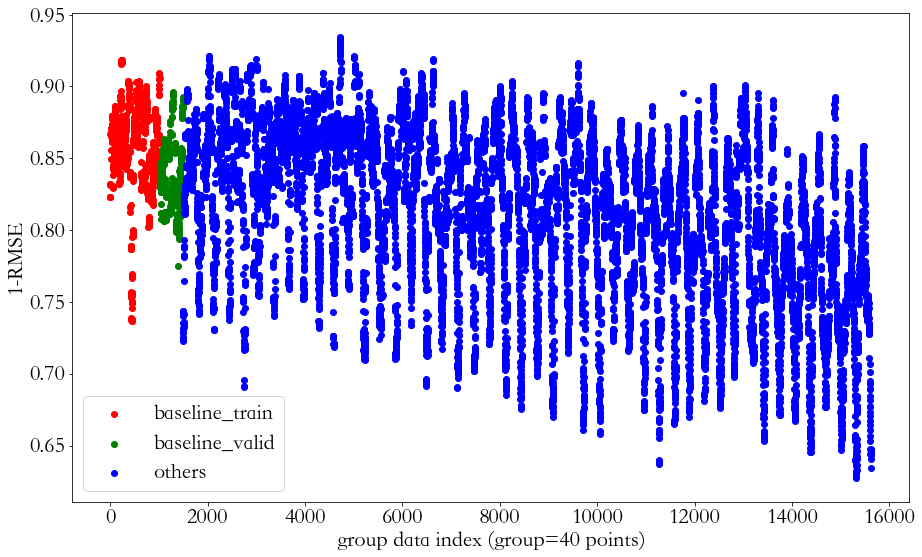

train, val, test, rms len:
654 120 13768


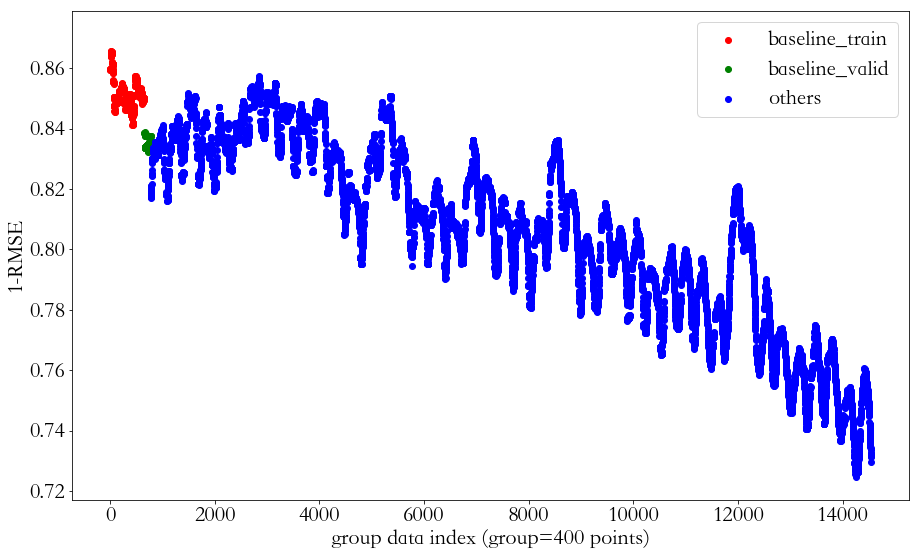

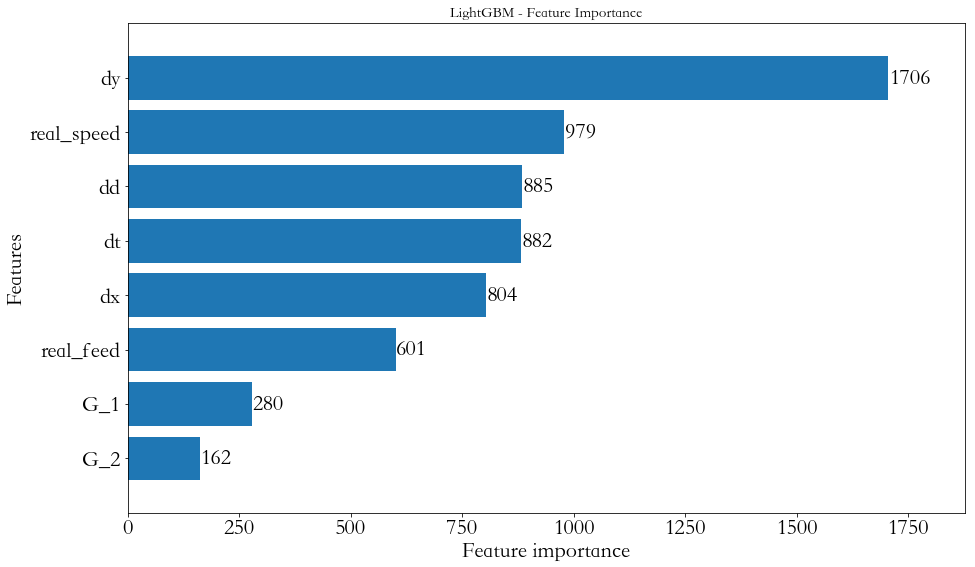

       real_feed  real_speed   dd   dx   dy   dt  G_1  G_2  G_3  real_y  \
count        0.0         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0   
mean         NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   
std          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   
min          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   
25%          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   
50%          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   
75%          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   
max          NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   

       pred_y  diff_y  
count     0.0     0.0  
mean      NaN     NaN  
std       NaN     NaN  
min       NaN     NaN  
25%       NaN     NaN  
50%       NaN     NaN  
75%       NaN     NaN  
max       NaN     NaN  
          real_feed    real_speed            dd            dx            dy  \
count  14122.000000  14122.00

In [8]:
df9_ori, df9_pro, df9_norm = Map('/Users/Zion/Downloads/9-PLC/')


M03S0032811.csv
M03S0032812.csv
M03S0032813.csv
M03S0032814.csv
M03S0032815.csv
M03S0032816.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:28:18.096745
ori_df len: 692959
692959
after process, df.len: 37185
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.203968
[200]	valid_0's rmse: 0.195038
[300]	valid_0's rmse: 0.191898
[400]	valid_0's rmse: 0.190719
[500]	valid_0's rmse: 0.190221
[600]	valid_0's rmse: 0.189926
[700]	valid_0's rmse: 0.189792
[800]	valid_0's rmse: 0.18981
Early stopping, best iteration is:
[722]	valid_0's rmse: 0.189752
train, val, test len:
2491 1227 33467
train, val, test, rms len:
2451 1187 33427


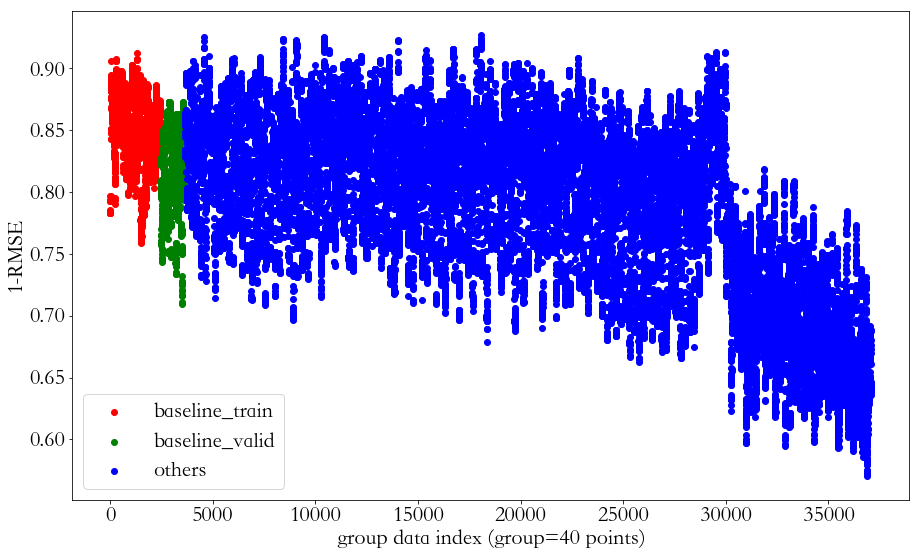

train, val, test, rms len:
2091 827 33067


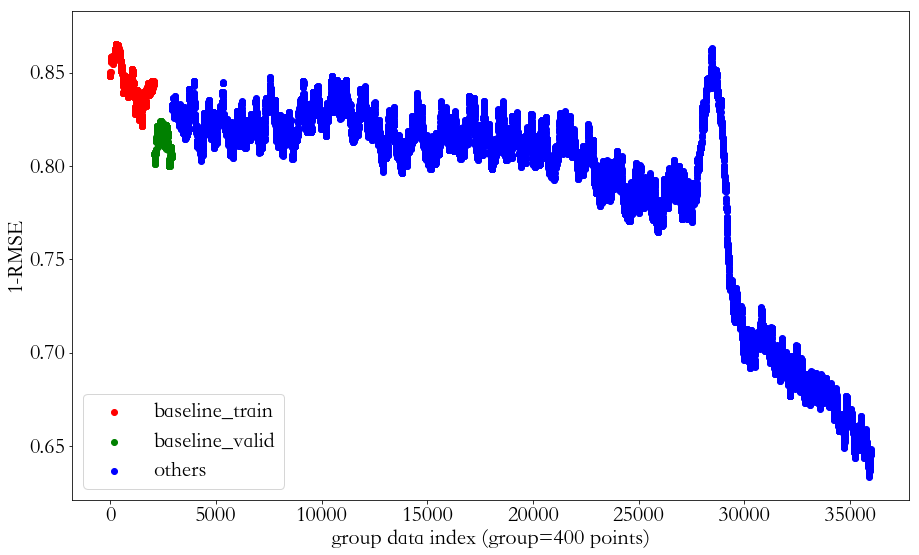

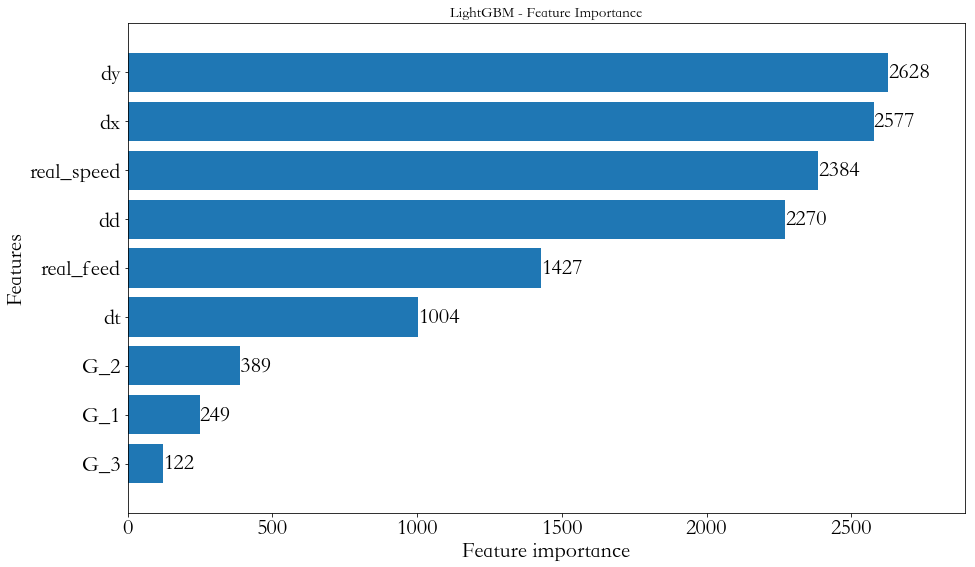

       real_feed  real_speed         dd         dx         dy         dt  \
count  76.000000   76.000000  76.000000  76.000000  76.000000  76.000000   
mean    0.717689    0.549595   0.245724   0.160560   0.177223   0.226801   
std     0.322932    0.159166   0.202028   0.183051   0.156398   0.065026   
min     0.026787    0.226496   0.000000   0.000000   0.000000   0.078947   
25%     0.431574    0.440171   0.000000   0.000000   0.000000   0.184211   
50%     0.853988    0.564103   0.286780   0.031844   0.211782   0.236842   
75%     1.000000    0.641026   0.441374   0.316526   0.310440   0.263158   
max     1.000000    0.884615   0.514792   0.524491   0.442695   0.447368   

             G_1        G_2   G_3     real_y     pred_y     diff_y  
count  76.000000  76.000000  76.0  76.000000  76.000000  76.000000  
mean    0.276316   0.723684   0.0   3.373298   2.609949   0.763349  
std     0.450146   0.450146   0.0   0.099214   0.118276   0.069080  
min     0.000000   0.000000   0.0   3.1

In [11]:
df10_ori, df10_pro, df10_norm = Map('/Users/Zion/Downloads/10-PLC/')




M03S0032809.csv
M03S0032810.csv
M03S0032811.csv
M03S0032812.csv
M03S0032813.csv
M03S0032814.csv
M03S0032815.csv
M03S0032816.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:30:17.508289
ori_df len: 758524
758524
after process, df.len: 34872
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.39647
[200]	valid_0's rmse: 0.386085
[300]	valid_0's rmse: 0.382515
[400]	valid_0's rmse: 0.381083
[500]	valid_0's rmse: 0.381083
Early stopping, best iteration is:
[453]	valid_0's rmse: 0.380875
train, val, test len:
2336 1151 31385
train, val, test, rms len:
2296 1111 31345


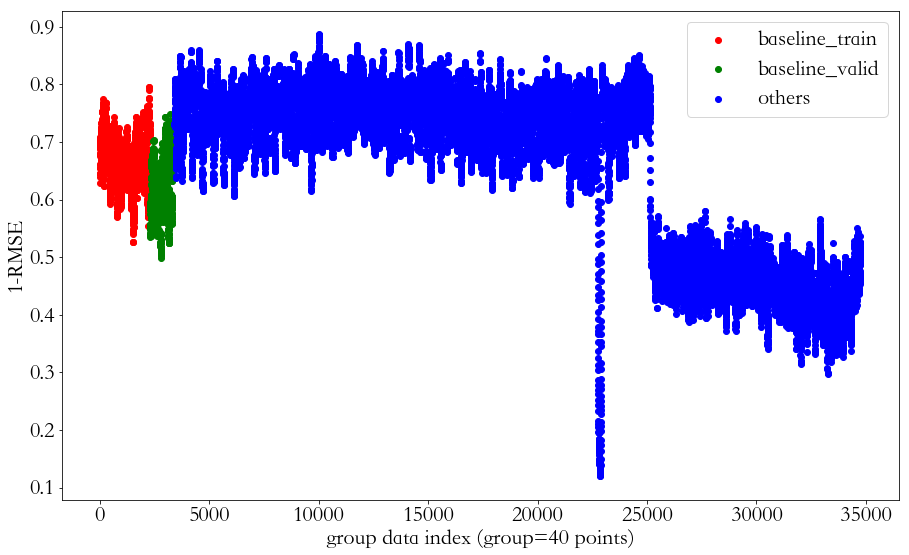

train, val, test, rms len:
1936 751 30985


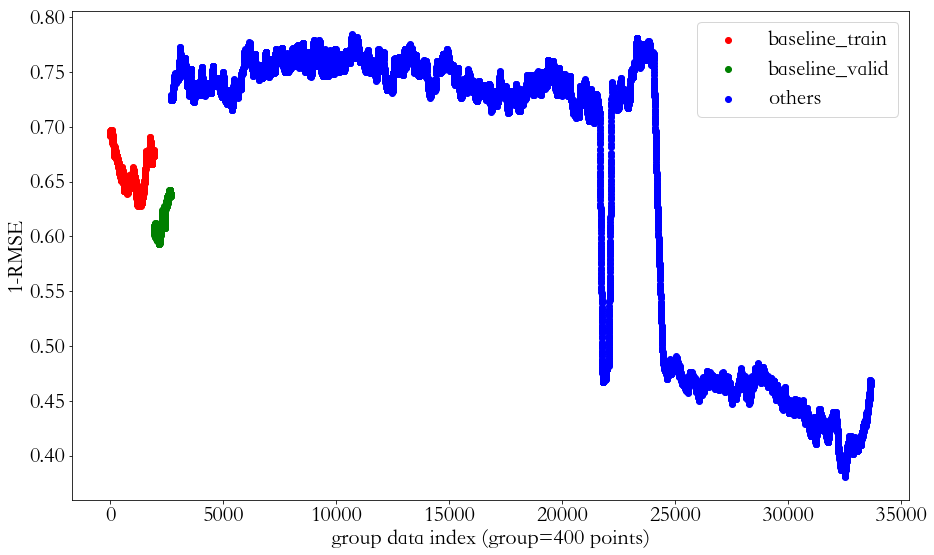

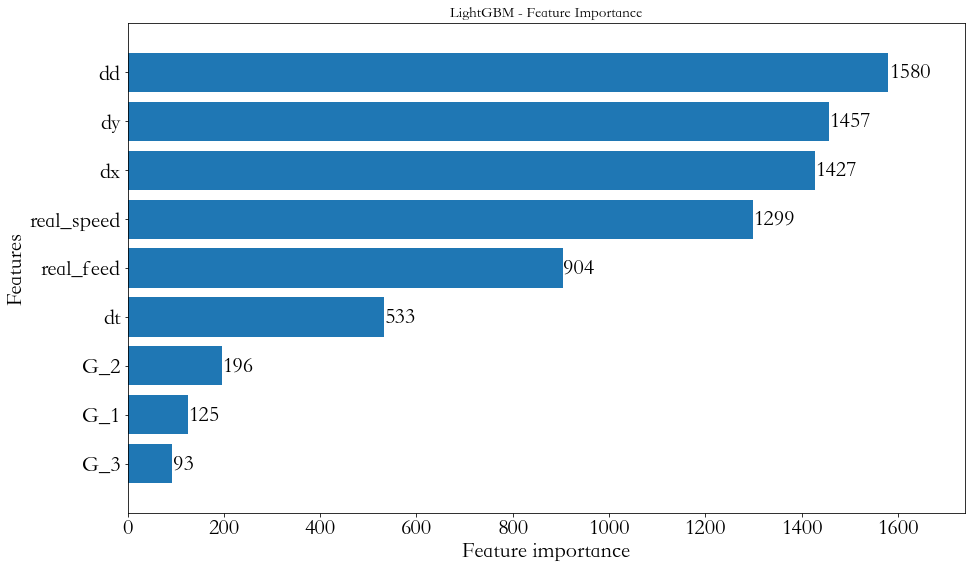

         real_feed   real_speed           dd           dx           dy  \
count  1794.000000  1794.000000  1794.000000  1794.000000  1794.000000   
mean      0.816622     0.435817     0.419464     0.233874     0.221124   
std       0.292973     0.068737     0.118244     0.218511     0.204628   
min       0.007339     0.041322     0.000000     0.000000     0.000000   
25%       0.675419     0.400826     0.378371     0.021557     0.002129   
50%       1.000000     0.433884     0.442022     0.129233     0.265776   
75%       1.000000     0.462810     0.501339     0.491245     0.410480   
max       1.000000     0.764463     1.000000     1.000000     1.000000   

                dt          G_1          G_2          G_3       real_y  \
count  1794.000000  1794.000000  1794.000000  1794.000000  1794.000000   
mean      0.232339     0.773690     0.221293     0.005017     3.341493   
std       0.064234     0.418559     0.415233     0.070671     0.153489   
min       0.000000     0.000000     0

In [12]:
df11_ori, df11_pro, df11_norm = Map('/Users/Zion/Downloads/11-PLC/')


M03S0032809.csv
M03S0032810.csv
M03S0032811.csv
M03S0032813.csv
M03S0032814.csv
M03S0032815.csv
M03S0032816.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:32:07.423024
ori_df len: 558850
558850
after process, df.len: 13599
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.444973
[200]	valid_0's rmse: 0.430097
[300]	valid_0's rmse: 0.423105
[400]	valid_0's rmse: 0.41968
[500]	valid_0's rmse: 0.418013
[600]	valid_0's rmse: 0.417752
[700]	valid_0's rmse: 0.417354
[800]	valid_0's rmse: 0.416923
[900]	valid_0's rmse: 0.416406
[1000]	valid_0's rmse: 0.416204
[1100]	valid_0's rmse: 0.415842
[1200]	valid_0's rmse: 0.41544
[1300]	valid_0's rmse: 0.415068
[1400]	valid_0's rmse: 0.415025
[1500]	valid_0's rmse: 0.414607
[1600]	valid_0's rmse: 0.414442
[1700]	valid_0's rmse: 0.414039
[1800]	valid_0's rmse

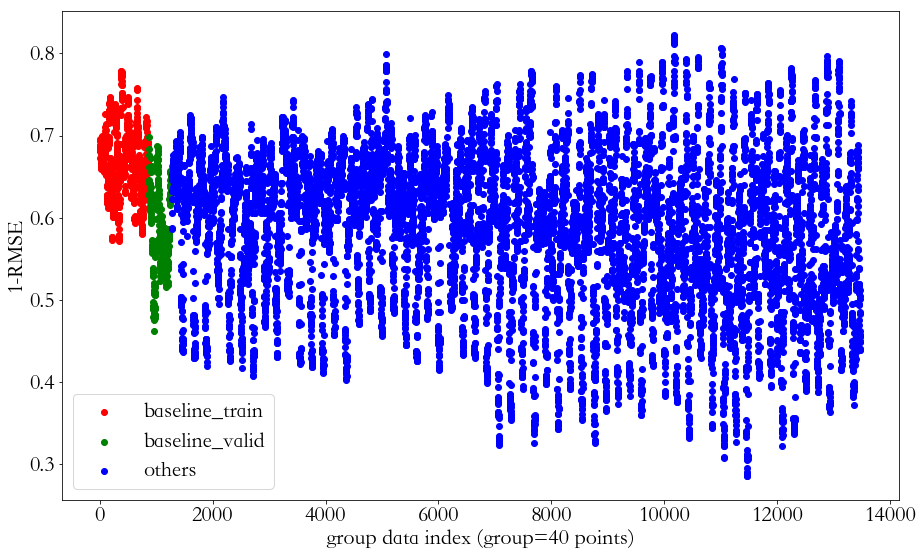

train, val, test, rms len:
510 49 11840


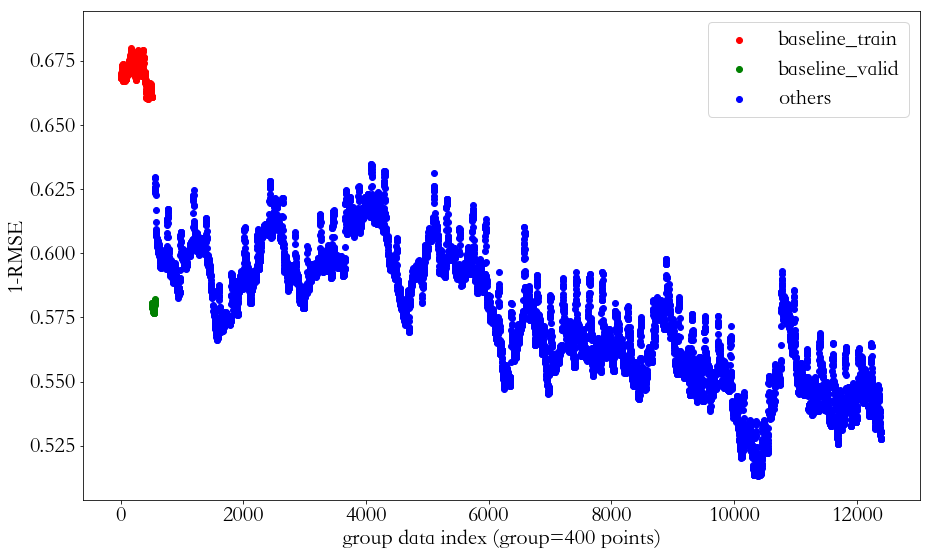

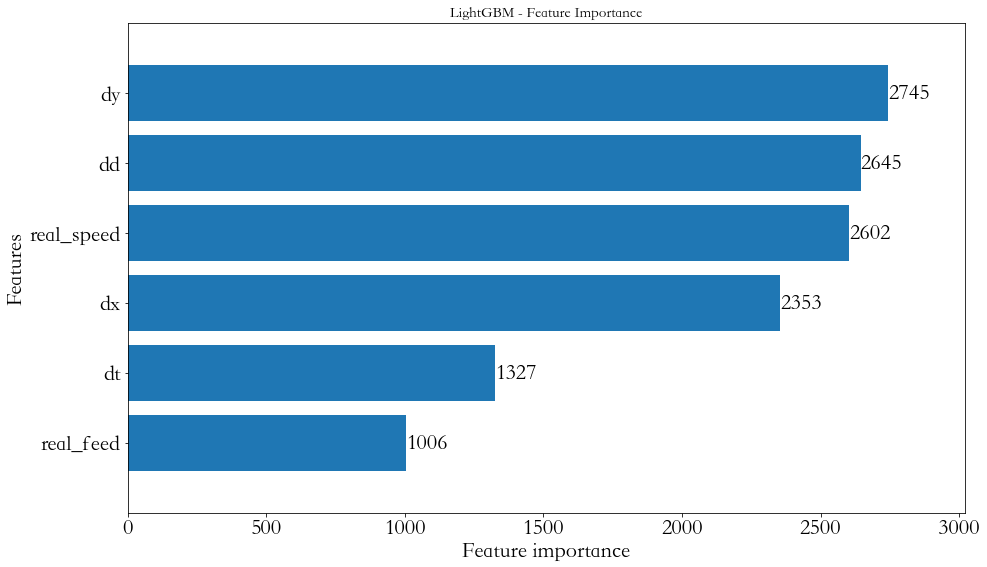

         real_feed   real_speed           dd           dx           dy  \
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000   
mean      0.925520     0.537182     0.432820     0.257385     0.188423   
std       0.199101     0.066714     0.097891     0.225912     0.218720   
min       0.016444     0.238994     0.000000     0.000000     0.000000   
25%       1.000000     0.490566     0.385092     0.000000     0.000000   
50%       1.000000     0.540881     0.475698     0.304431     0.005521   
75%       1.000000     0.584906     0.492188     0.490879     0.460937   
max       1.000000     0.830189     1.000000     1.000000     1.000000   

                dt          G_1          G_2          G_3       real_y  \
count  1204.000000  1204.000000  1204.000000  1204.000000  1204.000000   
mean      0.255807     0.905316     0.092193     0.002492     3.015554   
std       0.079191     0.292900     0.289418     0.049875     0.266907   
min       0.000000     0.000000     0

In [13]:
df12_ori, df12_pro, df12_norm = Map('/Users/Zion/Downloads/12-PLC/')


M03S00328070309.csv
M03S00328070310.csv
M03S00328070311.csv
M03S00328070312.csv
M03S00328070313.csv
M03S00328070314.csv
M03S00328070315.csv
M03S00328070316.csv
M03S00328070408.csv
M03S00328070409.csv
M03S00328070410.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:36:26.925141
ori_df len: 873390
873390
after process, df.len: 39362
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.187294
[200]	valid_0's rmse: 0.176035
[300]	valid_0's rmse: 0.171335
[400]	valid_0's rmse: 0.169203
[500]	valid_0's rmse: 0.16818
[600]	valid_0's rmse: 0.167683
[700]	valid_0's rmse: 0.16726
[800]	valid_0's rmse: 0.166964
[900]	valid_0's rmse: 0.166809
[1000]	valid_0's rmse: 0.166665
[1100]	valid_0's rmse: 0.166495
Early stopping, best iteration is:
[1096]	valid_0's rmse: 0.166494
train, val, test len:
2637 1299 35426


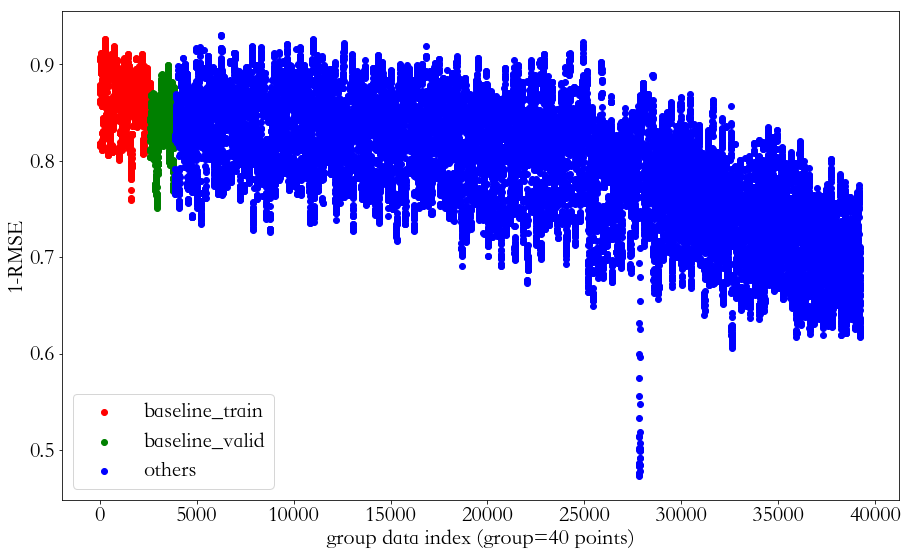

train, val, test, rms len:
2237 899 35026


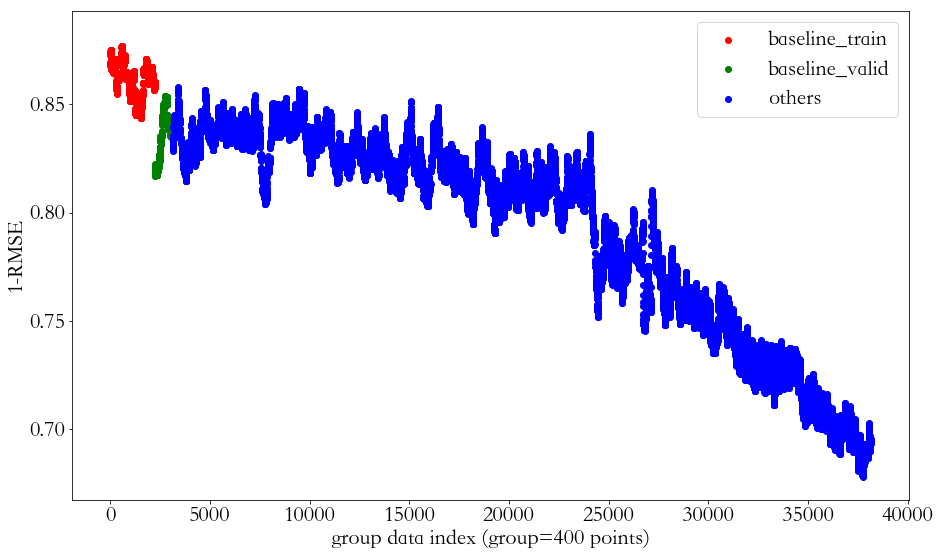

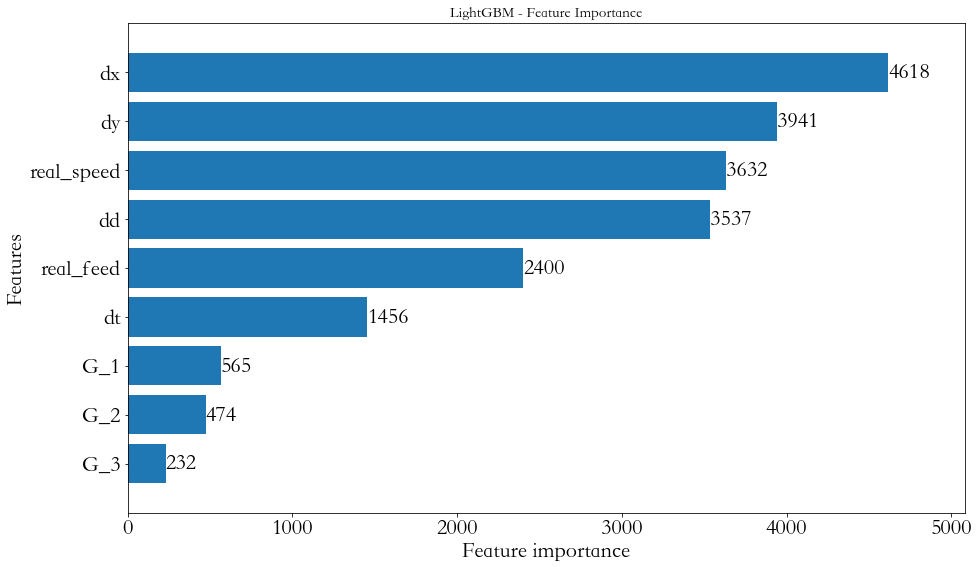

       real_feed  real_speed         dd         dx         dy         dt  \
count  29.000000   29.000000  29.000000  29.000000  29.000000  29.000000   
mean    0.669397    0.645271   0.248596   0.245561   0.160730   0.224138   
std     0.327713    0.100391   0.056797   0.133496   0.078205   0.076277   
min     0.032349    0.405941   0.110340   0.000067   0.034610   0.052632   
25%     0.419338    0.569307   0.219460   0.153675   0.083836   0.184211   
50%     0.801156    0.658416   0.249063   0.303567   0.166996   0.236842   
75%     0.992363    0.707921   0.288459   0.319677   0.247206   0.263158   
max     1.000000    0.797030   0.345983   0.429583   0.268775   0.342105   

             G_1        G_2   G_3     real_y     pred_y     diff_y  
count  29.000000  29.000000  29.0  29.000000  29.000000  29.000000  
mean    0.068966   0.931034   0.0   3.414811   2.678907   0.735904  
std     0.257881   0.257881   0.0   0.090540   0.095701   0.031792  
min     0.000000   0.000000   0.0   3.1

In [14]:
df13_ori, df13_pro, df13_norm = Map('/Users/Zion/Downloads/13-PLC/')


M03S00328070411.csv
M03S00328070412.csv
M03S00328070413.csv
M03S00328070414.csv
M03S00328070415.csv
M03S00328070416.csv
M03S00328070417.csv
M03S00328070618_.csv
M03S00328070619_.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:37:19.596270
ori_df len: 588462
588462
after process, df.len: 6941
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.226692
[200]	valid_0's rmse: 0.218793
[300]	valid_0's rmse: 0.214262
[400]	valid_0's rmse: 0.211288
[500]	valid_0's rmse: 0.209986
[600]	valid_0's rmse: 0.209205
[700]	valid_0's rmse: 0.208811
[800]	valid_0's rmse: 0.208607
[900]	valid_0's rmse: 0.208475
[1000]	valid_0's rmse: 0.208356
[1100]	valid_0's rmse: 0.208267
[1200]	valid_0's rmse: 0.208179
[1300]	valid_0's rmse: 0.208148
[1400]	valid_0's rmse: 0.20812
[1500]	valid_0's rmse: 0.208094
[1600]	valid_0'

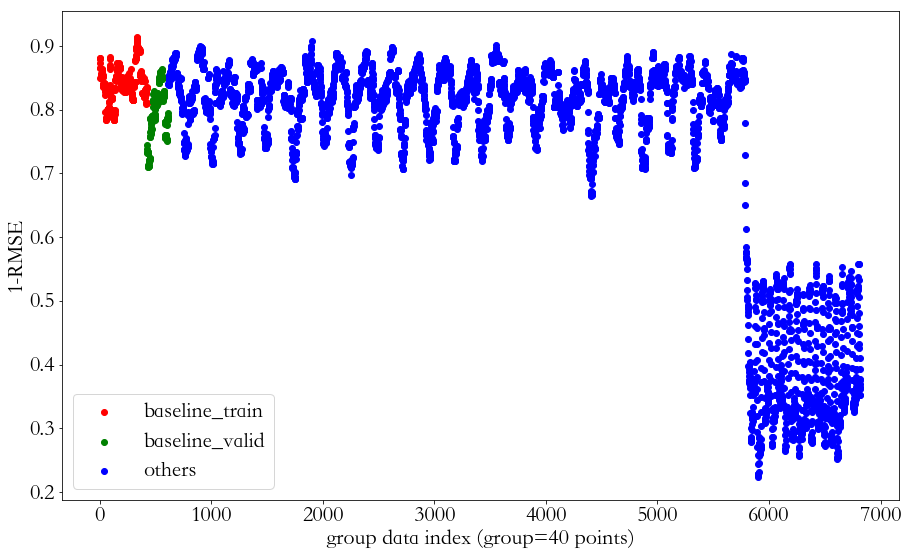

train, val, test, rms len:
64 0 5847


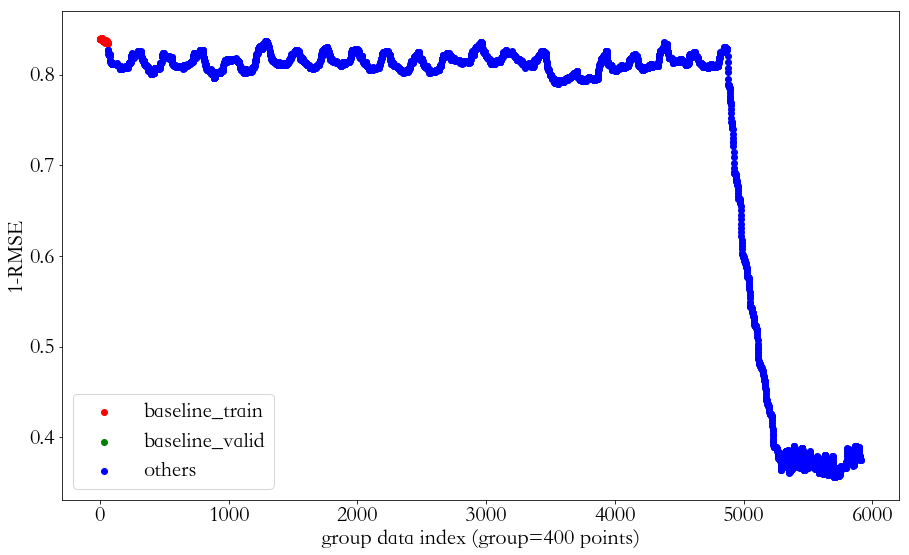

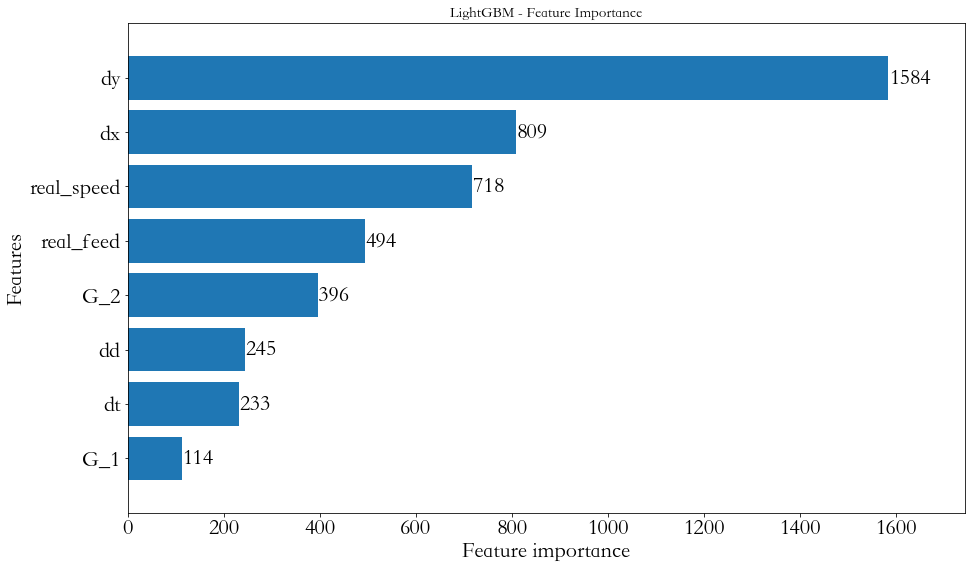

       real_feed  real_speed        dd        dx        dy        dt  \
count   5.000000    5.000000  5.000000  5.000000  5.000000  5.000000   
mean    0.747726    0.572455  0.190748  0.027014  0.359469  0.314286   
std     0.255820    0.035577  0.048746  0.026120  0.098548  0.063888   
min     0.415698    0.508982  0.165270  0.000000  0.298651  0.285714   
25%     0.593026    0.586826  0.167677  0.000253  0.309940  0.285714   
50%     0.729907    0.586826  0.169427  0.031602  0.325959  0.285714   
75%     1.000000    0.586826  0.173587  0.046498  0.328382  0.285714   
max     1.000000    0.592814  0.277777  0.056718  0.534414  0.428571   

            G_1       G_2  G_3    real_y    pred_y    diff_y  
count  5.000000  5.000000  5.0  5.000000  5.000000  5.000000  
mean   0.400000  0.600000  0.0  3.375552  2.617528  0.758024  
std    0.547723  0.547723  0.0  0.130043  0.110640  0.034692  
min    0.000000  0.000000  0.0  3.232446  2.510481  0.702807  
25%    0.000000  0.000000  0.0  3.27

In [15]:
df14_ori, df14_pro, df14_norm = Map('/Users/Zion/Downloads/14-PLC/')


M03S00328070614.csv
M03S00328070615.csv
M03S00328070616.csv
M03S00328070708.csv
M03S00328070709.csv
M03S00328070710.csv
M03S00328070711.csv
M03S00328070714.csv
M03S00328070715.csv
Index(['單節', '切削量', '設定進給', '設定轉速', '主軸負載', 'X軸機械座標', 'Y軸機械座標', 'Z軸機械座標',
       '切削時常', '實際進給', '實際轉速', '進給率', 'file', 'time', 'dx', 'dy', 'dz'],
      dtype='object')
Read_plc() finish!!!
time cost: 0:39:43.871814
ori_df len: 655686
655686
after process, df.len: 22986
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.317992
[200]	valid_0's rmse: 0.287852
[300]	valid_0's rmse: 0.276792
[400]	valid_0's rmse: 0.271329
[500]	valid_0's rmse: 0.268289
[600]	valid_0's rmse: 0.265987
[700]	valid_0's rmse: 0.264177
[800]	valid_0's rmse: 0.262951
[900]	valid_0's rmse: 0.262267
[1000]	valid_0's rmse: 0.26168
[1100]	valid_0's rmse: 0.261068
[1200]	valid_0's rmse: 0.260625
[1300]	valid_0's rmse: 0.260251
[1400]	valid_0's rmse: 0.260054
[1500]	valid_0's rmse: 0.259904
[1600]	valid_0's

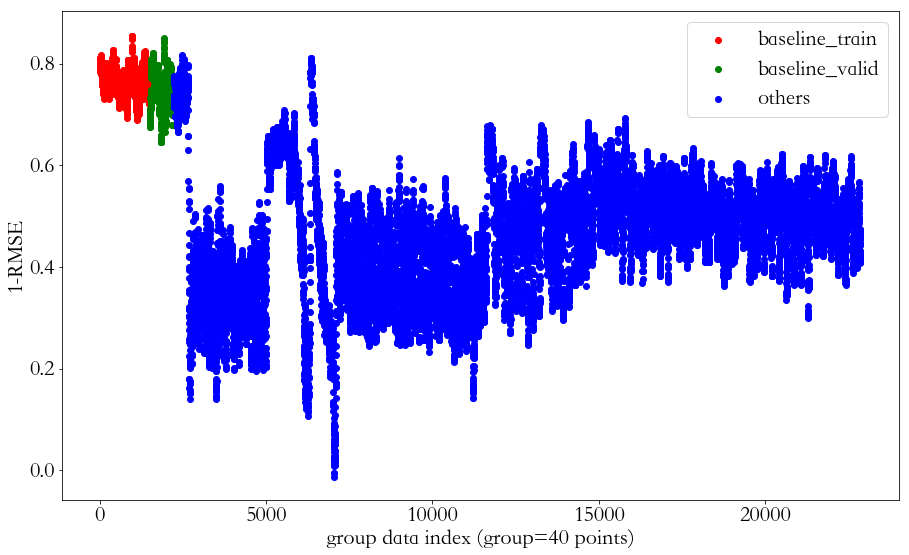

train, val, test, rms len:
1139 359 20288


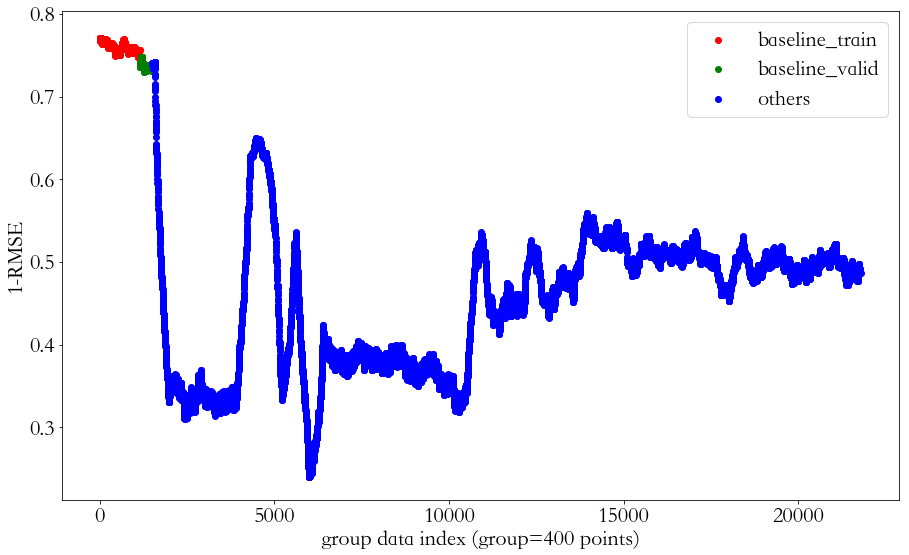

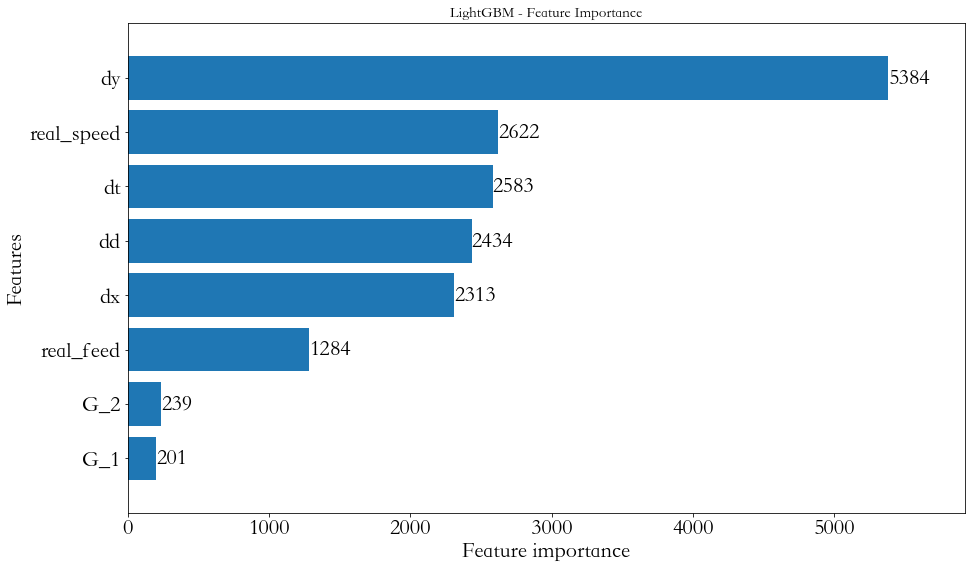

         real_feed   real_speed           dd           dx           dy  \
count  3118.000000  3118.000000  3118.000000  3118.000000  3118.000000   
mean      0.907460     0.534564     0.433223     0.398225     0.058826   
std       0.235333     0.091574     0.108629     0.152496     0.125870   
min       0.001179     0.158163     0.000000     0.000000     0.000000   
25%       1.000000     0.479592     0.394026     0.352223     0.000070   
50%       1.000000     0.535714     0.474035     0.468053     0.002866   
75%       1.000000     0.586735     0.500000     0.499976     0.013770   
max       1.000000     0.979592     0.981169     0.981169     0.659510   

                dt          G_1          G_2          G_3       real_y  \
count  3118.000000  3118.000000  3118.000000  3118.000000  3118.000000   
mean      0.273105     0.843169     0.138871     0.017960     3.156138   
std       0.085438     0.363700     0.345867     0.132828     0.202966   
min       0.000000     0.000000     0

In [17]:
df15_ori, df15_pro, df15_norm = Map('/Users/Zion/Downloads/15-PLC/')
